In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
import copy
import pandas as pd

warnings.filterwarnings('ignore')

import sys
import os
import numpy as np
import joblib
import torch

PYOM_DIR = "./datasets/pymo"
if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser
from pymo.preprocessing import *
from pymo.viz_tools import draw_stickfigure, draw_stickfigure3d
from sklearn.pipeline import Pipeline

print("✅ Imports successful!")

print("\n📦 Creating pipeline...")

# ✅ CORRECT PIPELINE DEFINITION
pipeline = Pipeline([
    ('param', MocapParameterizer('position')),
    ('rcpn', RootCentricPositionNormalizer()),
    ('delta', RootTransformer('absolute_translation_deltas')),
    ('const', ConstantsRemover()),
    ('np', Numpyfier()),
    ('down', DownSampler(2)),
    ('stdscale', ListStandardScaler())
])

print("   Pipeline created with steps:")
for name, step in pipeline.steps:
    print(f"     - {name}: {step.__class__.__name__}")

bvh_sample_path = "./datasets/2_scott_0_55_55.bvh"
print(f"\n   Fitting on: {os.path.basename(bvh_sample_path)}")

if os.path.exists(bvh_sample_path):
    parser = BVHParser()
    parsed_data = parser.parse(bvh_sample_path)
    pipeline.fit([parsed_data])
    print("   ✅ Pipeline fitted!")
else:
    print(f"   ❌ Error: BVH file not found at {bvh_sample_path}")
    sys.exit(1)

✅ Imports successful!

📦 Creating pipeline...
   Pipeline created with steps:
     - param: MocapParameterizer
     - rcpn: RootCentricPositionNormalizer
     - delta: RootTransformer
     - const: ConstantsRemover
     - np: Numpyfier
     - down: DownSampler
     - stdscale: ListStandardScaler

   Fitting on: 2_scott_0_55_55.bvh
   ✅ Pipeline fitted!


In [2]:
import torch
from models import MotionTransformer
from utils.get_opt import get_opt
import numpy as np
from os.path import join as pjoin
from trainers import DDPMTrainer

encoder = MotionTransformer(
        input_feats=264,
        num_frames=360,
        num_layers=8,
        latent_dim=512,
        no_clip=False,
        no_eff=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
opt_path = "./checkpoints/beat/test/opt.txt"
opt = get_opt(opt_path, device)
opt.do_denoise = True

mean = np.load(pjoin(opt.meta_dir, 'mean.npy'))
std = np.load(pjoin(opt.meta_dir, 'std.npy'))
trainer = DDPMTrainer(opt, encoder)
# trainer.load(pjoin(opt.model_dir, opt.which_epoch + '.tar'))
trainer.load("./checkpoints/beat/test/model/ckpt_e010.tar")

trainer.eval_mode()
trainer.to(opt.device)

result_dict = {}
with torch.no_grad():
        caption = ["the first thing i like to do on weekends is relaxing and i'll go shopping if i'm not that tired"]
        m_lens = torch.LongTensor([300]).to(device)
        pred_motions = trainer.generate(caption, m_lens, 264)
        motion = pred_motions[0].cpu().numpy()
        print(motion.shape)
opt.result_dir = "./checkpoints/beat/test"
np.save(pjoin(opt.result_dir, 'motion_010.npy'), motion)

Reading ./checkpoints/beat/test/opt.txt


100%|██████████| 1000/1000 [00:23<00:00, 42.88it/s]

(300, 264)


In [3]:
def constrain_to_ref_skeleton(generated_mocap, ref_mocap):
    print(" -> Đang 'ép' khung xương theo Reference (Scott)...")
    
    queue = [ref_mocap.root_name]
    processed = set([ref_mocap.root_name])
    
    gen_df = generated_mocap.values
    
    while queue:
        parent_name = queue.pop(0)
        children = ref_mocap.skeleton[parent_name]['children']
        
        for child_name in children:
            if child_name not in generated_mocap.skeleton:
                continue
                
            ref_offset = np.array(ref_mocap.skeleton[child_name]['offsets'])
            target_bone_length = np.linalg.norm(ref_offset)

            if target_bone_length < 1e-6:
                queue.append(child_name)
                continue

            p_x = gen_df[f"{parent_name}_Xposition"]
            p_y = gen_df[f"{parent_name}_Yposition"]
            p_z = gen_df[f"{parent_name}_Zposition"]
            
            c_x = gen_df[f"{child_name}_Xposition"]
            c_y = gen_df[f"{child_name}_Yposition"]
            c_z = gen_df[f"{child_name}_Zposition"]
            
            vec_x = c_x - p_x
            vec_y = c_y - p_y
            vec_z = c_z - p_z
            
            current_lens = np.sqrt(vec_x**2 + vec_y**2 + vec_z**2)
            
            current_lens[current_lens == 0] = 1e-6
            
            scale_factor = target_bone_length / current_lens
            
            new_vec_x = vec_x * scale_factor
            new_vec_y = vec_y * scale_factor
            new_vec_z = vec_z * scale_factor
            
            gen_df[f"{child_name}_Xposition"] = p_x + new_vec_x
            gen_df[f"{child_name}_Yposition"] = p_y + new_vec_y
            gen_df[f"{child_name}_Zposition"] = p_z + new_vec_z
            
            queue.append(child_name)
            
    print(" -> Hoàn tất Retargeting!")
    return generated_mocap


 Loading Mean/Std from Meta files...
    Đã tìm thấy Mean và Std từ file .npy
   Shape của Mean: (264,)
   Shape của Std: (264,)
   Mean (5 giá trị đầu): [ 0.03488945 -0.01222794 -0.01634861  0.03422788 -0.01150454]

 Overriding pipeline statistics with meta values...
    Pipeline updated with meta statistics!

 Visualizing: motion_010.npy
   Motion shape: (300, 264)
   Performing inverse transform...
positions 2 eulers is not supported
 -> Đang 'ép' khung xương theo Reference (Scott)...
 -> Hoàn tất Retargeting!

   Creating 2D visualization (Corrected Skeleton)...


<Figure size 1000x800 with 0 Axes>

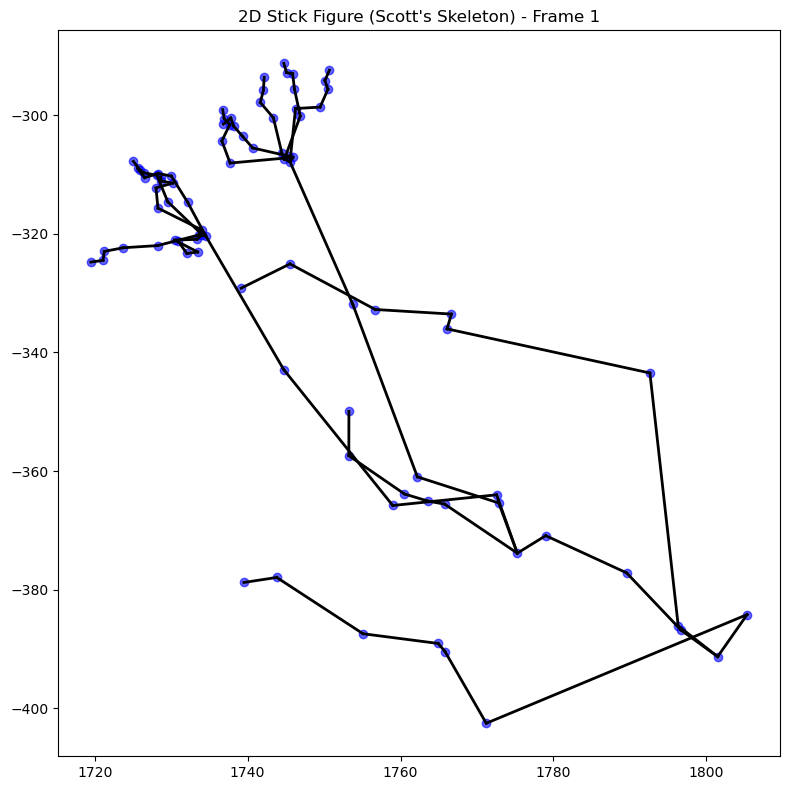


   Creating 3D visualization (Corrected Skeleton)...


<Figure size 1000x800 with 0 Axes>

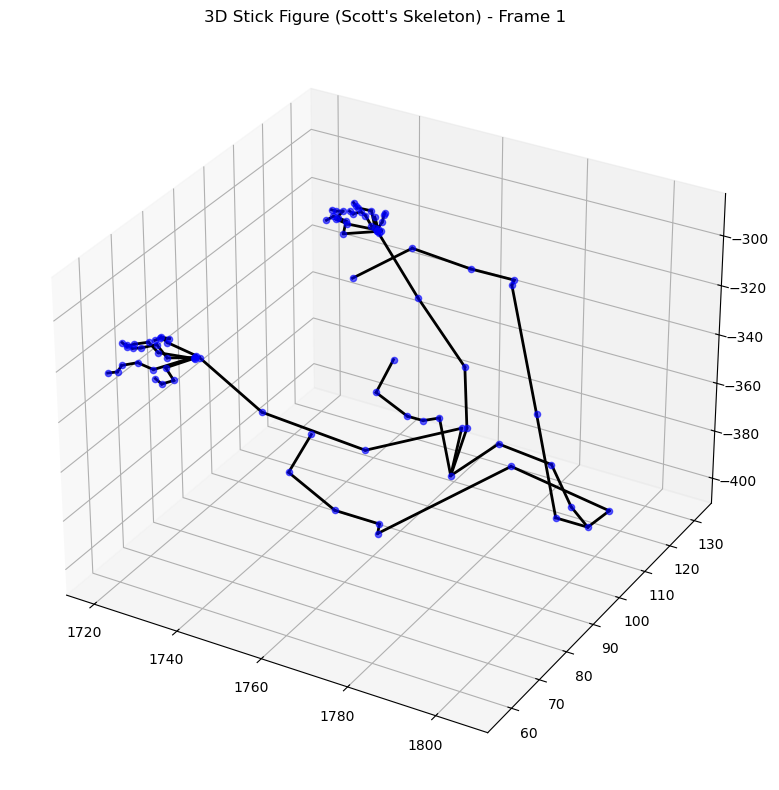

    Done!


In [4]:
meta_dir = "./checkpoints/beat/test/meta"
mean_path = os.path.join(meta_dir, "mean.npy")
std_path = os.path.join(meta_dir, "std.npy")

print("\n Loading Mean/Std from Meta files...")
try:
    mean = np.load(mean_path)
    std = np.load(std_path)

    print("    Đã tìm thấy Mean và Std từ file .npy")
    print(f"   Shape của Mean: {mean.shape}")
    print(f"   Shape của Std: {std.shape}")
    print(f"   Mean (5 giá trị đầu): {mean[:5]}")
    
    print("\n Overriding pipeline statistics with meta values...")
    pipeline.named_steps['stdscale'].data_mean_ = mean
    pipeline.named_steps['stdscale'].data_std_ = std
    print("    Pipeline updated with meta statistics!")

except Exception as e:
    print(f" Có lỗi xảy ra khi load meta: {e}")
    sys.exit(1)

npy_path = "./checkpoints/beat/test/motion_010.npy"
frame = 1

print(f"\n Visualizing: {os.path.basename(npy_path)}")

if os.path.exists(npy_path):
    motion_data = np.load(npy_path)
    print(f"   Motion shape: {motion_data.shape}")
    motion_data = motion_data * std + mean

    print("   Performing inverse transform...")
    generated_list = pipeline.inverse_transform([motion_data])
    generated_mocap = generated_list[0]
    
    if 'parsed_data' not in globals():
        parser = BVHParser()
        ref_mocap = parser.parse("./datasets/2_scott_0_55_55.bvh")
    else:
        ref_mocap = parsed_data 
        
    generated_mocap = constrain_to_ref_skeleton(generated_mocap, ref_mocap)
    # =============================================

    print("\n   Creating 2D visualization (Corrected Skeleton)...")
    fig1 = plt.figure(figsize=(10, 8))
    draw_stickfigure(generated_mocap, frame=frame) 
    plt.title(f"2D Stick Figure (Scott's Skeleton) - Frame {frame}")
    plt.tight_layout()
    plt.show()

    print("\n   Creating 3D visualization (Corrected Skeleton)...")
    fig2 = plt.figure(figsize=(10, 8))
    draw_stickfigure3d(generated_mocap, frame=frame)
    plt.title(f"3D Stick Figure (Scott's Skeleton) - Frame {frame}")
    plt.tight_layout()
    plt.show()
    
    print("    Done!")

DIAGNOSTIC: File Test Data
Shape: (164, 264)
Stats: min=-2.91, max=5.32, mean=0.14, std=0.83

🔍 Hypothesis 1: Đã là POSITION format?
  ❌ Có vẻ là AXIS-ANGLE format (giá trị nhỏ)

🔍 Hypothesis 2: So sánh với training reference
  ❌ Không tìm thấy reference file Scott

🔍 Hypothesis 3: Thử dùng PIPELINE inverse_transform


positions 2 eulers is not supported
  ✅ Pipeline inverse_transform thành công!
     Output shape: (164, 264)
     Columns: ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition', 'Spine_Xposition', 'Spine_Yposition']


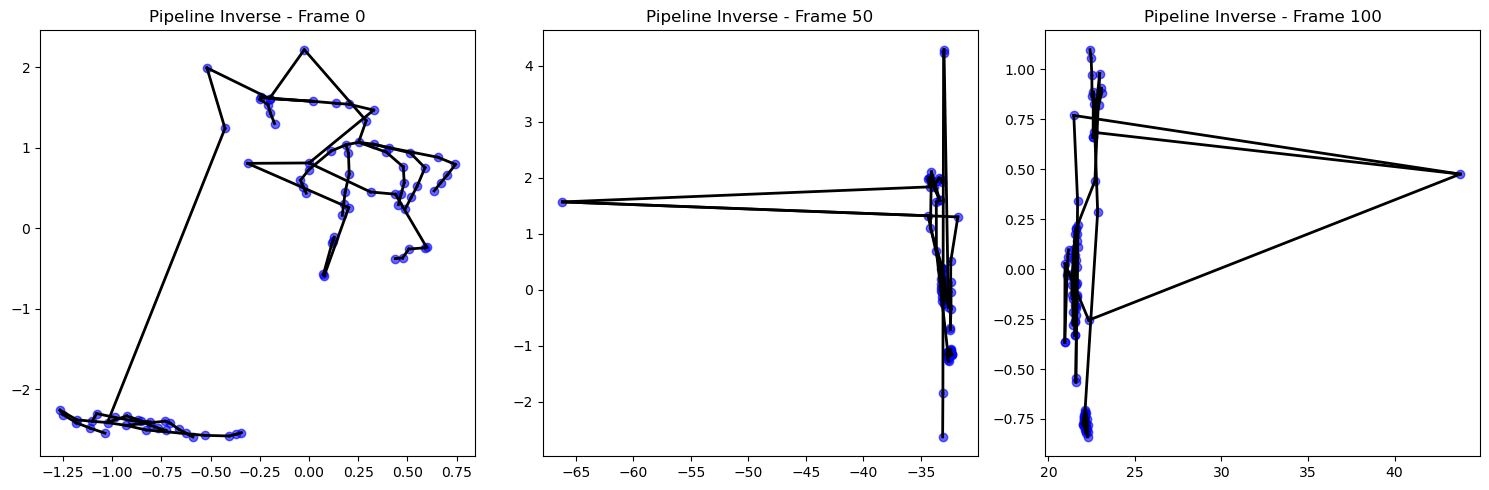

  ✅ Pipeline visualization done!



In [5]:
# ============================================
# DIAGNOSTIC: Kiểm tra định dạng data thực tế
# ============================================

import numpy as np

test_file = "./datasets/BEAT_numpy/npy/1/1_wayne_0_1_1_sentence_000.npy"
m_raw = np.load(test_file)

print("="*60)
print("DIAGNOSTIC: File Test Data")
print("="*60)
print(f"Shape: {m_raw.shape}")
print(f"Stats: min={m_raw.min():.2f}, max={m_raw.max():.2f}, mean={m_raw.mean():.2f}, std={m_raw.std():.2f}")

# Hypothesis 1: Kiểm tra nếu nó đã là position format (values lớn)
print("\n🔍 Hypothesis 1: Đã là POSITION format?")
if m_raw.max() > 100 or m_raw.min() < -100:
    print("  ✅ Có vẻ là POSITION format (giá trị lớn)")
else:
    print("  ❌ Có vẻ là AXIS-ANGLE format (giá trị nhỏ)")

# Hypothesis 2: So sánh với reference training data
print("\n🔍 Hypothesis 2: So sánh với training reference")
ref_file = "./datasets/BEAT_numpy/npy/1/1_scott_0_1_1_sentence_000.npy"
try:
    m_ref = np.load(ref_file)
    print(f"  Reference file: {ref_file}")
    print(f"  Ref shape: {m_ref.shape}")
    print(f"  Ref stats: min={m_ref.min():.2f}, max={m_ref.max():.2f}, mean={m_ref.mean():.2f}, std={m_ref.std():.2f}")
    
    # Compare
    if np.allclose(m_raw.mean(), m_ref.mean(), atol=0.5):
        print("  ✅ Mean gần nhau → Cùng format và chuẩn hoá")
    else:
        print(f"  ⚠️ Mean khác: test={m_raw.mean():.2f} vs ref={m_ref.mean():.2f}")
except:
    print("  ❌ Không tìm thấy reference file Scott")

# Hypothesis 3: Thử inverse_transform trực tiếp với pipeline
print("\n🔍 Hypothesis 3: Thử dùng PIPELINE inverse_transform")
try:
    # Giả sử m_raw đã là format của pipeline
    m_processed = m_raw * std + mean  # denorm
    result = pipeline.inverse_transform([m_processed])
    mocap_pipeline = result[0]
    
    print(f"  ✅ Pipeline inverse_transform thành công!")
    print(f"     Output shape: {mocap_pipeline.values.shape}")
    print(f"     Columns: {list(mocap_pipeline.values.columns[:5])}")
    
    # Visualize
    from pymo.viz_tools import draw_stickfigure
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    for i, frame in enumerate([0, 50, 100]):
        ax = axes[i]
        draw_stickfigure(mocap_pipeline, frame=min(frame, len(mocap_pipeline.values)-1), ax=ax)
        ax.set_title(f"Pipeline Inverse - Frame {frame}")
    plt.tight_layout()
    plt.show()
    
    print("  ✅ Pipeline visualization done!")
    
except Exception as e:
    print(f"  ❌ Pipeline error: {e}")

print("\n" + "="*60)

Testing Pipeline with Training Reference Data

1️⃣ Reference BVH loaded
   Frames: 3720
   Columns (first 5): ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition', 'Hips_Xrotation', 'Hips_Yrotation']

2️⃣ Pipeline forward (fit_transform):
   Output shape: (1860, 264)
   Output stats: min=-5.0743, max=8.2037
positions 2 eulers is not supported

3️⃣ Pipeline inverse:
   Output shape: (1860, 264)
   Output columns (first 5): ['Hips_Xposition', 'Hips_Yposition', 'Hips_Zposition', 'Spine_Xposition', 'Spine_Yposition']
   Output stats: min=-102.3161, max=83.2759


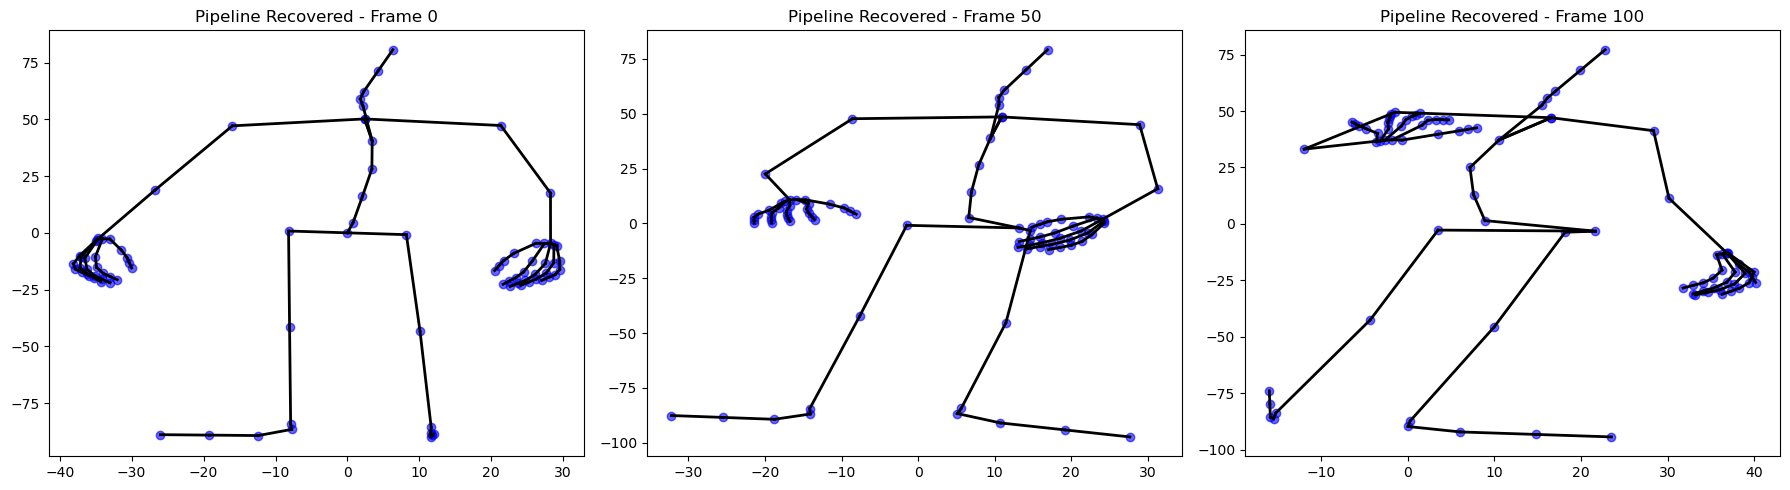


✅ Pipeline test complete
   ℹ️ If skeleton looks normal → pipeline OK!
   ℹ️ If skeleton is garbage → pipeline has issue with DownSampler or inverse logic


In [6]:
# ============================================
# DEBUG: Kiểm tra pipeline với training reference
# ============================================

import copy

print("="*60)
print("Testing Pipeline with Training Reference Data")
print("="*60)

# Load actual training BVH (reference)
parser = BVHParser()
ref_bvh = parser.parse("./datasets/2_scott_0_55_55.bvh")
print(f"\n1️⃣ Reference BVH loaded")
print(f"   Frames: {len(ref_bvh.values)}")
print(f"   Columns (first 5): {list(ref_bvh.values.columns[:5])}")

# Process through pipeline (forward)
ref_processed = pipeline.fit_transform([ref_bvh])
print(f"\n2️⃣ Pipeline forward (fit_transform):")
print(f"   Output shape: {ref_processed[0].shape}")
print(f"   Output stats: min={ref_processed[0].min():.4f}, max={ref_processed[0].max():.4f}")

# Now inverse it back
ref_recovered = pipeline.inverse_transform(ref_processed)
print(f"\n3️⃣ Pipeline inverse:")
print(f"   Output shape: {ref_recovered[0].values.shape}")
print(f"   Output columns (first 5): {list(ref_recovered[0].values.columns[:5])}")
print(f"   Output stats: min={ref_recovered[0].values.min().min():.4f}, max={ref_recovered[0].values.max().max():.4f}")

# Visualize ONLY recovered (ref_bvh doesn't have position columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

frames_to_check = [0, 50, 100]
for i, f in enumerate(frames_to_check):
    ax = axes[i]
    frame_idx = min(f, len(ref_recovered[0].values)-1)
    draw_stickfigure(ref_recovered[0], frame=frame_idx, ax=ax)
    ax.set_title(f"Pipeline Recovered - Frame {f}")

plt.tight_layout()
plt.show()

print("\n✅ Pipeline test complete")
print("   ℹ️ If skeleton looks normal → pipeline OK!")
print("   ℹ️ If skeleton is garbage → pipeline has issue with DownSampler or inverse logic")


In [7]:
import sys
import numpy as np
import os

# --- Cấu hình đường dẫn ---
PYOM_DIR = "./datasets/pymo"
# File mẫu dùng để lấy cấu trúc xương (dùng file Wayne như pipeline của bạn)
BVH_SAMPLE_PATH = "./datasets/2_scott_0_55_55.bvh"

if PYOM_DIR not in sys.path:
    sys.path.insert(0, PYOM_DIR)

from pymo.parsers import BVHParser

def extract_beat_params():
    if not os.path.exists(BVH_SAMPLE_PATH):
        print(f"❌ Error: Không tìm thấy file {BVH_SAMPLE_PATH}")
        return

    print(f"📖 Parsing: {os.path.basename(BVH_SAMPLE_PATH)}...")
    parser = BVHParser()
    parsed_data = parser.parse(BVH_SAMPLE_PATH)
    
    # Lấy danh sách tên khớp để debug (nếu cần)
    joint_names = list(parsed_data.skeleton.keys())
    
    # 1. Trích xuất Raw Offsets
    # Offsets trong BVH là khoảng cách từ khớp cha đến khớp con ở T-pose
    offsets = []
    for name in joint_names:
        off = parsed_data.skeleton[name]['offsets']
        offsets.append(off)
    
    raw_offsets = np.array(offsets)
    
    # 2. Xây dựng Kinematic Chain tự động
    # Logic: Tìm các chuỗi liên kết (Root -> Head, Root -> Extremities)
    # Lưu ý: Đây là heuristic cơ bản để nhóm các khớp thành chuỗi như T2M
    
    # Xác định các chuỗi chính dựa trên tên khớp chuẩn của BEAT (Mixamo/SMPL-X naming)
    # BEAT thường dùng: Hips, Spine..., Neck, Head
    #                   RightUpLeg..., RightFoot...
    #                   LeftUpLeg..., LeftFoot...
    #                   RightShoulder..., RightHand...
    #                   LeftShoulder..., LeftHand...
    
    # Helper để tìm indices từ danh sách tên
    def get_indices(search_names):
        indices = []
        for search in search_names:
            found = False
            for idx, name in enumerate(joint_names):
                if search in name: # Partial match
                    indices.append(idx)
                    found = True
                    break
        return indices

    # Định nghĩa cấu trúc thủ công dựa trên tên khớp BEAT để đảm bảo chính xác
    # Bạn có thể cần điều chỉnh string match nếu tên trong BVH khác biệt
    
    # Thân (Spine -> Head)
    spine_chain = get_indices(['Hips', 'Spine', 'Spine1', 'Spine2', 'Spine3', 'Neck', 'Head', 'HeadTop_End'])
    
    # Chân phải (Right Leg)
    r_leg_chain = get_indices(['Hips', 'RightUpLeg', 'RightLeg', 'RightFoot', 'RightForeFoot', 'RightToeBase'])
    
    # Chân trái (Left Leg)
    l_leg_chain = get_indices(['Hips', 'LeftUpLeg', 'LeftLeg', 'LeftFoot', 'LeftForeFoot', 'LeftToeBase'])
    
    # Tay phải (Right Arm) - Chỉ lấy đến cổ tay (Hand), ngón tay tính riêng
    r_arm_chain = get_indices(['Spine3', 'RightShoulder', 'RightArm', 'RightForeArm', 'RightHand'])
    
    # Tay trái (Left Arm)
    l_arm_chain = get_indices(['Spine3', 'LeftShoulder', 'LeftArm', 'LeftForeArm', 'LeftHand'])

    # Tổng hợp kinematic chain cơ bản (Body)
    kinematic_chain = [spine_chain, r_leg_chain, l_leg_chain, r_arm_chain, l_arm_chain]
    
    # Lọc bỏ các chain rỗng (đề phòng sai tên)
    kinematic_chain = [c for c in kinematic_chain if len(c) > 1]

    print("\n" + "="*40)
    print("📋 KẾT QUẢ ĐỂ COPY VÀO paramUtil.py")
    print("="*40)
    
    print("\nbeat_raw_offsets = np.array(")
    print(np.array2string(raw_offsets, separator=', ', precision=4, suppress_small=True))
    print(")")

    print("\nbeat_kinematic_chain = [")
    for chain in kinematic_chain:
        print(f"    {chain},")
    print("]")
    
    print(f"\n# Tổng số khớp phát hiện: {len(joint_names)}")
    if len(joint_names) == 55:
        print("✅ Số lượng khớp khớp với cấu hình opt.joints_num = 55!")
    else:
        print(f"⚠️ Cảnh báo: Số lượng khớp là {len(joint_names)}, khác với 55. Hãy kiểm tra lại opt.joints_num.")

if __name__ == "__main__":
    extract_beat_params()

📖 Parsing: 2_scott_0_55_55.bvh...

📋 KẾT QUẢ ĐỂ COPY VÀO paramUtil.py

beat_raw_offsets = np.array(
[[  0.    ,   0.    ,   0.    ],
 [  0.    ,   6.2699,  -2.2649],
 [  0.    ,  12.4786,  -2.2003],
 [  0.    ,  12.6229,  -1.1044],
 [  0.    ,  12.6711,   0.    ],
 [  0.    ,  16.2915,   1.6291],
 [  0.    ,   3.4568,   0.3024],
 [  0.    ,   3.4173,   0.6026],
 [  0.    ,   9.7277,  -0.    ],
 [  0.    ,   9.7277,  -0.    ],
 [  0.    ,  11.6368,   5.8792],
 [-19.5534,   0.    ,   0.    ],
 [-30.6236,   0.    ,   0.    ],
 [-25.4584,   0.    ,   0.    ],
 [ -9.3283,   0.    ,   0.    ],
 [ -4.9315,   0.    ,   0.    ],
 [ -3.1771,   0.    ,   0.    ],
 [ -1.9277,   0.    ,   0.    ],
 [ -1.9276,   0.    ,   0.    ],
 [ -0.25  ,  -0.25  ,  -0.8556],
 [ -8.2287,   0.    ,  -0.7426],
 [ -4.5791,   0.    ,  -0.4132],
 [ -3.0897,   0.    ,  -0.2788],
 [ -1.9088,   0.    ,  -0.1723],
 [ -1.9088,   0.    ,  -0.1723],
 [ -0.1721,  -0.25  ,  -0.8746],
 [ -6.8125,   0.    ,  -1.5234],
 [ -3.617

VISUALIZING MODEL OUTPUT FROM NPY

📂 Loaded: ./checkpoints/beat/test/motion_010.npy
   Shape: (300, 264)
   Stats: min=-4981.48, max=5703.57

✅ Denormalized
   Stats: min=-4749.31, max=5702.42
positions 2 eulers is not supported

✅ Pipeline inverse_transform
   Output shape: (300, 264)
 -> Đang 'ép' khung xương theo Reference (Scott)...
 -> Hoàn tất Retargeting!

🎨 Visualizing...


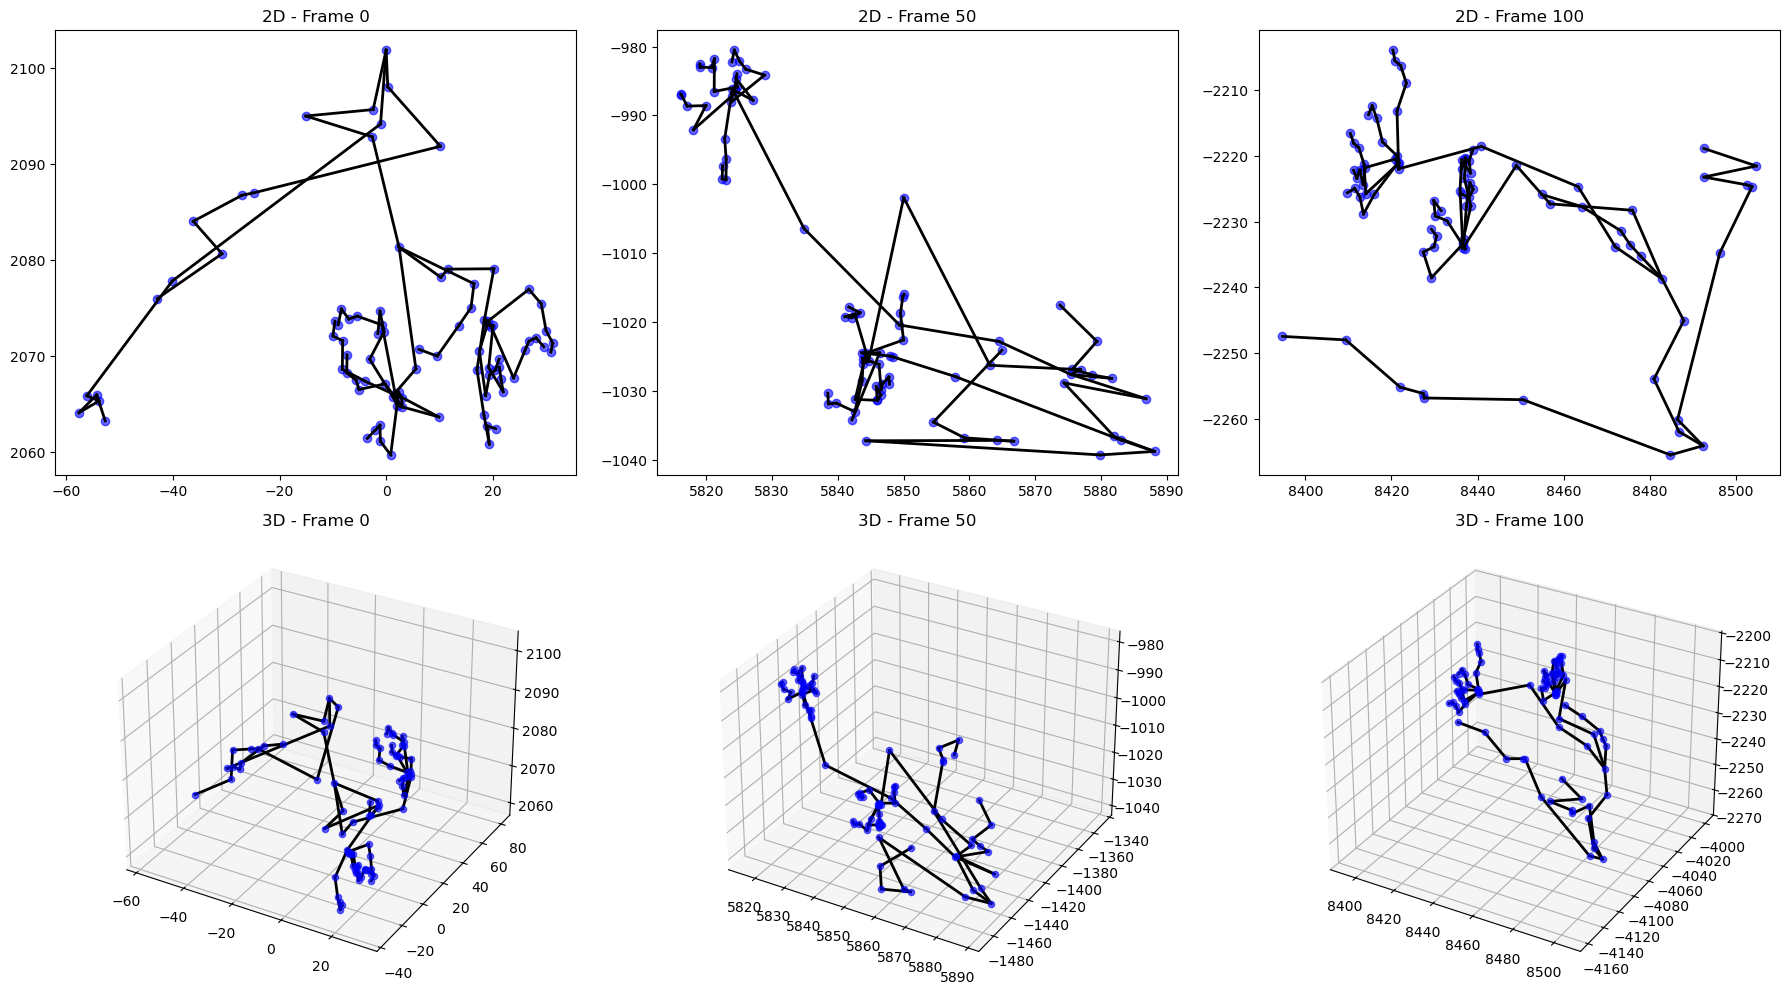


✅ Visualization complete!


In [8]:
# ============================================
# FINAL: Visualize Model Output (npy) using Pipeline
# ============================================

print("="*60)
print("VISUALIZING MODEL OUTPUT FROM NPY")
print("="*60)

npy_file = "./checkpoints/beat/test/motion_010.npy"
m_model = np.load(npy_file)

print(f"\n📂 Loaded: {npy_file}")
print(f"   Shape: {m_model.shape}")
print(f"   Stats: min={m_model.min():.2f}, max={m_model.max():.2f}")

# Step 1: Denormalize
m_denorm = m_model * std + mean
print(f"\n✅ Denormalized")
print(f"   Stats: min={m_denorm.min():.2f}, max={m_denorm.max():.2f}")

# Step 2: Inverse transform
try:
    result = pipeline.inverse_transform([m_denorm])
    mocap_final = result[0]
    print(f"\n✅ Pipeline inverse_transform")
    print(f"   Output shape: {mocap_final.values.shape}")
    
    # Step 3: Constrain to reference skeleton
    parser_ = BVHParser()
    ref_mocap = parser_.parse("./datasets/2_scott_0_55_55.bvh")
    mocap_final = constrain_to_ref_skeleton(mocap_final, ref_mocap)
    
    # Step 4: Visualize
    print(f"\n🎨 Visualizing...")
    fig = plt.figure(figsize=(18, 10))
    
    frames = [0, 50, 100]
    for i, f in enumerate(frames):
        frame_idx = min(f, len(mocap_final.values)-1)
        
        # 2D
        ax2d = fig.add_subplot(2, 3, i+1)
        draw_stickfigure(mocap_final, frame=frame_idx, ax=ax2d)
        ax2d.set_title(f"2D - Frame {f}")
        
        # 3D
        ax3d = fig.add_subplot(2, 3, i+4, projection='3d')
        draw_stickfigure3d(mocap_final, frame=frame_idx, ax=ax3d)
        ax3d.set_title(f"3D - Frame {f}")
    
    plt.tight_layout()
    plt.show()
    
    print("\n✅ Visualization complete!")
    
except Exception as e:
    print(f"\n❌ Error: {e}")
    import traceback
    traceback.print_exc()
